# I. DeZero Framework 만들기
***

In [1]:
pwd

'/home/myhwang/deep-learning-from-scratch-3'

In [1]:
#from steps.framework_base import *
from steps.diff import *
from dezero import *
import contextlib
import numpy as np
import graphviz
import dezero.functions as F

# 1. class input 1개로 구현

In [3]:
from steps.framework_base import Variable
# class Variable:
#     def __init__(self, data):
#         self.data = data

In [4]:
import numpy as np

x=Variable(np.array(10))

x.data

array(10)

In [5]:
from steps.function import *

# class Function:
#     def __call__(self, *args: Any, **kwds: Any) -> Any:
#         x = input.data
#         y = self.forward(x)
#         output = Variable(y)
#         return output
    
#     def forward(self, in_data):
#         raise NotImplementedError()
#     #matric의 함수를 호출하지 않고 그냥 Function을 호출시 에러 호출

하위 클래스 matric의 함수를 호출하지 않아서 에러

In [6]:
# f=Function()
# y=f(x)

# output>> NotImplementedError: 

In [7]:
from steps.matric import *
# class Square(Function):
#     def forward(self, x):
#         output = x**2
#         return output

# class Exp(Function):
#     def forward(self, x):
#         output=np.exp(x)
#         return output
x=Variable(np.array(10))

f1=Square()
y1=f1(x)
print(y1.data)

f2=Exp()
y2=f2(y1)
print(y2.data)

y3=f1(y2)
print(y3.data)

100
2.6881171418161356e+43
7.22597376812575e+86


In [8]:
from steps.diff import *

f=Square()
x=Variable(2.0)
dy1=centered_diff(f,x)
print(dy1)

dy2=forward_diff(f,x)
print(dy2)


TypeError: <class 'float'>은(는) 지원하지 않습니다.

In [ ]:
def f(x):
    A=Square()
    B=Exp()
    C=Square()
    return C(B(A(x)))

x=Variable(np.array(0.5))
dy=centered_diff(f,x)
print(dy)

3.2974426293330694


In [ ]:
A=Square()
B=Exp()
C=Square()

x=Variable(np.array(0.5))
a=A(x)
b=B(a)
y=C(b)

y.grad= np.array(1.0)
b.grad=C.backward(y.grad) #function의 backward(self, gy)
a.grad=B.backward(b.grad)
x.grad=A.backward(a.grad)

print(x.grad)



3.297442541400256


재귀 방식을 이용한 backward 구현

In [ ]:
A=Square()
B=Exp()
C=Square()

x=Variable(np.array(0.5))
a=A(x)
b=B(a)
y=C(b)

y.grad= np.array(1.0)
y.backward() #variable의 backward(self)
print(x.grad)

3.297442541400256


반복문을 이용한 backward 구현

In [ ]:
A=Square()
B=Exp()
C=Square()

x=Variable(np.array(0.5))
a=A(x)
b=B(a)
y=C(b)

y.grad= np.array(1.0)
y.backward() #variable의 backward(self)
print(x.grad)

3.297442541400256


matric Class 함수화, backward grad 자동생성

# 2. input 여러개로 수정

In [9]:
x=Variable(np.array([0.5,0.3]))
y=exp(x)

y.backward()
print(x.grad)

[1.64872127 1.34985881]


In [10]:
x=Variable(0.5)
y=square(exp(square(x)))

y.backward()
print(x.grad)

TypeError: <class 'float'>은(는) 지원하지 않습니다.

In [ ]:
def as_array(x):
    if np.isscalar(x):
        return np.array(x)
    return x

x=0.5
type(as_array(x))

numpy.ndarray

In [11]:
x0=Variable(np.array(2.0))
x1=Variable(np.array(3.0))

y=add(square(x0),square(x1))
y.backward()
print(y.data)
print(x0.grad)
print(x1.grad)

13.0
4.0
6.0


함수 세대를 고려한 역전파 알고리즘으로 수정

In [4]:
#약한 참조 이전
x=Variable(np.array(2.0))
a=square(x)
y=add(square(a),square(a)) #y=2.0^8
y.backward()
print(y.data)
print(a.grad)
print(x.grad)


32.0
16.0
96.0


# 3.메모리 관리

In [3]:
#약한 참조 이후
x=Variable(np.array(2.0))
a=square(x)
y=add(square(a),square(a)) #y=2.0^8
y.backward()
print(y.data)
print(a.grad)
print(x.grad)


32.0
None
64.0


In [4]:
#약한 참조 이후(중간 변수의 미분값을 알기위해서는 retain_grad=True 옵션 필요)
x=Variable(np.array(2.0))
a=square(x)
y=add(square(a),square(a)) #y=2.0^8
y.backward(retain_grad=True)
print(y.data)
print(a.grad)
print(x.grad)


32.0
16.0
64.0


with문 활용

In [4]:
import contextlib

@contextlib.contextmanager
def config_test():
    print('start')
    try:
        yield #예외를 실행하는 코드 try/finaly로 감싸야한다
    finally:
        print('done')

with config_test():
    print('process..')


start
process..
done


In [5]:
class Config:  # 역전파 여부를 결정하는 코드
    enable_backprop = True


@contextlib.contextmanager
def using_config(name, value):
    old_value = getattr(Config, name)
    setattr(Config, name, value)
    try:
        yield
    finally:
        setattr(Config, name, old_value)

In [9]:
with using_config('enable_backprop',False):
    x=Variable(np.array(2.0))
    y=square(x)

print(y.grad)

None


In [11]:
def no_grad():
    return using_config('enable_backprop',False)

with no_grad():
    x=Variable(np.array(2.0))
    y=square(x)

print(y.grad)

None


# 4. 변수 사용성 개선

변수 이름 지정

In [3]:
#class Variable:
#   def __init__(self, data, name=None):
#       self.name = name

x=Variable(np.array(1.0),'input_x')
x.name

'input_x'

인스턴스 변수 생성

In [3]:
# @property
# def shape(self):
#     return self.data.shape

# @property
# def ndim(self):
#     return self.data.ndim

# @property
# def size(self):
#     return self.data.size

# @property
# def dtype(self):
#     return self.data.dtype

x=Variable(np.array([[1,2,3],[4,5,6]]))
print(x.shape)
print(x.ndim)
print(x.size)
print(x.dtype)

(2, 3)
2
6
int64


특수 매서드 __len __ , \_\_repr\_\_(print 변경)

In [4]:
# def __len__(self):
#     return len(self.data)

len(x)

2

In [5]:
# def __repr__(self):
#     if self.data is None:
#         return 'variable(None)'
#     p = str(self.data).replace('\n', '\n'+' '*9)
#     return 'variable('+p+')'
x
p = str(x.data).replace('\n', '\n'+' '*9)
print(p)
print('variable('+p+')')

# __repr__ 사용
print(x)

[[1 2 3]
          [4 5 6]]
variable([[1 2 3]
          [4 5 6]])
variable([[1 2 3]
          [4 5 6]])


# 5. 연산자 오버로드

Mul class 구현 (*)

In [5]:
# class Mul():
#     def forward(x0, x1):
#         y = x0*x1
#         return y

#     def backward(self, gy):
#         x0, x1 = self.inputs[0].data, self.inputs[1].data
#         return gy*x1, gy*x0


# def mul(x0, x1):
#     f = Mul()
#     return f(x0, x1)

a=Variable(np.array(3.0))
b=Variable(np.array(2.0))
c=Variable(np.array(1.0))

y=add(mul(a,b),c)

y.backward()

print(y)
print(a.grad)
print(b.grad)
print(c.grad)



variable(7.0)
2.0
3.0
1.0


\_\_mul\_\_연산자 오버로드

In [4]:
# def __mul__(self, other):
#     return mul(self, other)

a=Variable(np.array(3.))
b=Variable(np.array(2.))
y=a*b
print(y)


variable(6.0)


\_\_add\_\_ 연산자 오버로드

In [3]:
# Variable.__add__ = add
a = Variable(np.array(3.0))
b = Variable(np.array(2.0))
c = Variable(np.array(1.0))

y = a * b + c
y.backward()

print(y)
print(a.grad)
print(b.grad)

variable(7.0)
2.0
3.0


np.array 오브젝트 Variable 인스턴스로 변환

In [3]:
# def as_variable(obj):
#     if isinstance(obj, Variable):
#         return obj
#     return Variable(obj)
#
#inputs = [as_variable(x) for x in inputs]

x=Variable(np.array(2.))
y=x+np.array(3.) #np.array 인스턴스 Variable 인스턴스로 변환

print(y)

variable(5.0)


add,mul 연산의 우항 as_array적용 & \_\_radd\_\_, \_\_rmul\_\_ 생성

In [3]:
# Variable.__radd__ = add
# Variable.__rmul__ = mul

# def add(x0, x1):
#     x1 = as_array(x1)
#     f = Add()
#     return f(x0, x1)

# def mul(x0, x1):
#     x1 = as_array(x1)
#     f = Mul()
#     return f(x0, x1)

x=Variable(np.array(2.))
y=3.0*x+1.0
print(y)

variable(7.0)


__nef__생성

In [5]:
x=Variable(np.array(2.))
y=-x

y.backward()
print(y)
print(x.grad)

variable(-2.0)
-1.0


\_\_sub\_\_ & \_\_rsub\_\_ 생성

In [8]:
x=Variable(np.array(2.))
y1=2.0-x
y2=x-1.0

y1.backward()
y2.backward()

print(y1)
print(y2)
print(x.grad)

variable(0.0)
variable(1.0)
0.0


In [1]:
from steps.framework_base import *
from steps.diff import *
import contextlib

# 6.dezero 패키지로 정리

dezero 임포트

In [1]:
if '__file__' in globals():
    import os,sys
    sys.path.append(os.path.join(os.path.dirname(__file__),'..'))

import numpy as np
from dezero import Variable

x=Variable(np.array(1.))
y=(x+3)**2
y.backward()

print(y)
print(x.grad)

variable(16.0)
8.0


# 7.복잡한 함수의 미분

In [5]:
def sphere(x,y):
    z= x**2+y**2
    return z

x=Variable(np.array(1.))
y=Variable(np.array(1.))
z=sphere(x,y)
z.backward()

print(z)
print(x.grad,y.grad)

variable(2.0)
2.0 2.0


In [6]:
def matyas(x,y):
    z=0.26*(x**2+y**2)-0.48*x*y
    return z

x=Variable(np.array(1.))
y=Variable(np.array(1.))
z=matyas(x,y)
z.backward()

print(z)
print(x.grad,y.grad)

variable(0.040000000000000036)
0.040000000000000036 0.040000000000000036


In [12]:
def goldstein(x,y):
    # 가독성을 위한 줄바꿈 문자 \
    z=(1 + (x + y + 1)**2 * (19 - 14*x + 3*x**2 - 14*y + 6*x*y + 3*y**2)) * \
           (30 + (2*x - 3*y)**2 * (18 - 32*x + 12*x**2 + 48*y - 36*x*y + 27*y**2))
    return z
 
x=Variable(np.array(1.))
y=Variable(np.array(1.))
z=goldstein(x,y)
z.backward()

print(z)
print(x.grad,y.grad)

variable(1876.0)
-5376.0 8064.0


# 8.계산 그래프 시각화

In [ ]:
# digraph g{
#     x
#     y
# }

# digraph g{
#     x [color=orange, style=filled]
#     y [color=orange, style=filled]
#     exp [color=lightblue, style=filled, shape=box]

#     x->exp
#     y->exp
# }

In [18]:
def _dot_var(v, verbose=False):
    dot_var = '{} [lable="{}", color=orange, style=filled]\n'

    name = '' if v.name is None else v.name
    if verbose and v.data is not None:
        if v.name is not None:
            name += ':'
        name += str(v.shape) + ' ' + str(v.dtype)
    return dot_var.format(id(v), name)

x=Variable(np.random.randn(2,3))
x.name='x'
print(_dot_var(x))
print(_dot_var(x, verbose=True))

140143319066416 [lable="x", color=orange, style=filled]

140143319066416 [lable="x:(2, 3) float64", color=orange, style=filled]



In [19]:
def _dot_func(f):
    dot_func = '{} [lable="{}", color=lightblue, style=filled, shape=box]\n'
    txt=dot_func.format(id(f), f.__class__.__name__)

    dot_edge= '{}->{}\n'
    for x in f.inputs:
        txt += dot_edge.format(id(x), id(f))
    for y in f.outputs:
        txt += dot_edge.format(id(f), id(y()))
    return txt

x0=Variable(np.array(1.))
x1=Variable(np.array(1.))
y=x0+x1
txt=_dot_func(y.creator)
print(txt)

140143318432016 [lable="Add", color=lightblue, style=filled, shape=box]
140143318431008->140143318432016
140143318433744->140143318432016
140143318432016->140143318431824



dezero.utils의 plot_dot_graph 생성

- .dot 파일은 .dezero 폴더에 tmp_graph.dot으로 생성

In [1]:
import numpy as np
from dezero import Variable
from dezero.utils import plot_dot_graph

def goldstein(x,y):
    # 가독성을 위한 줄바꿈 문자 \
    z=(1 + (x + y + 1)**2 * (19 - 14*x + 3*x**2 - 14*y + 6*x*y + 3*y**2)) * \
           (30 + (2*x - 3*y)**2 * (18 - 32*x + 12*x**2 + 48*y - 36*x*y + 27*y**2))
    return z
 
x=Variable(np.array(1.))
y=Variable(np.array(1.))
z=goldstein(x,y)
z.backward()

print(z)
print(x.grad,y.grad)

x.name = 'x'
y.name = 'y'
z.name = 'z'
plot_dot_graph(z, verbose=False, to_file='goldstein.png')

variable(1876.0)
-5376.0 8064.0


![nn](/home/myhwang/deep-learning-from-scratch-3/goldstein.png)

# 9.테일러 급수 미분

sin 함수 구현

In [13]:
from dezero.core_simple import sin

x=Variable(np.array(np.pi/4))
y=sin(x)
y.backward()

print(y.data)
print(x.grad)


0.7071067811865476
0.7071067811865477


sin 함수 테일러 급수로 구현

In [14]:
import math
def my_sin(x, threshold=0.0001):
    y=0
    for i in range(100000):
        c = (-1)**i / math.factorial(2*i+1)
        t= c* x** (2*i+1)
        y= y+t
        if abs(t.data) < threshold:
            break
    return y

x=Variable(np.array(np.pi/4))
y=my_sin(x)
y.backward()

print(y.data)
print(x.grad)



0.7071064695751781
0.7071032148228457


# 10. 함수최적화

rosenbrock 함수 구현

In [17]:
def rosenbrock(x0, x1):
    y=100*(x1-x0**2)**2+(1-x0)**2
    return y

x0=Variable(np.array(0.0))
x1=Variable(np.array(2.0))

y=rosenbrock(x0,x1)
y.backward()
print(x0.grad, x1.grad)

-2.0 400.0


경사하강법으로 rosenbrock 최적화 <실제 최소 지점 (1,1)>

In [19]:
x0=Variable(np.array(0.0))
x1=Variable(np.array(2.0))
lr= 0.001
iters = 10000 #1000에서 0.6 부근에서 멈춤

for i in range(iters):
    print(x0,x1)

    y=rosenbrock(x0, x1)
    x0.cleargrad()
    x1.cleargrad()
    y.backward()

    x0.data -= lr * x0.grad
    x1.data -= lr * x1.grad

variable(0.0) variable(2.0)
variable(0.002) variable(1.6)
variable(0.0052759968) variable(1.2800008)
variable(0.009966698110960038) variable(1.0240062072284468)
variable(0.01602875299014943) variable(0.8192248327970044)
variable(0.02324750923068761) variable(0.6554312504220874)
variable(0.031290846214210376) variable(0.5244530896747561)
variable(0.039780241951514035) variable(0.41975829515116514)
variable(0.04835473570612382) variable(0.3361231296508763)
variable(0.05671405943493354) variable(0.26936613981374286)
variable(0.06463840226323121) variable(0.2161362087585121)
variable(0.07198937826156711) variable(0.17374459161623834)
variable(0.07869927242171229) variable(0.14003216740948807)
variable(0.08475507379959696) variable(0.11326444902353183)
variable(0.0901819257435144) variable(0.0920482437257805)
variable(0.09502862514911821) variable(0.07526515092678615)
variable(0.09935624532071949) variable(0.062018208660975245)
variable(0.10322996680416148) variable(0.05158889962562639)
var

뉴턴 방법을 활용한 최적화 구현

In [36]:
import numpy as np
from dezero import Variable

def f(x):
    y= x** 4 -2 * x ** 2
    return y

#2차 미분이 구현이 안 되어 있어 수동으로 구현
def gx2(x):
    return 12 * x ** 2 -4

x=Variable(np.array(2.))
iters= 10

for i in range(iters):
    print(i,x)

    y=f(x)

    x.cleargrad()
    y.backward()

    x.data -= x.grad / gx2(x.data)


0 variable(2.0)
1 variable(1.4545454545454546)
2 variable(1.1510467893775467)
3 variable(1.0253259289766978)
4 variable(1.0009084519430513)
5 variable(1.0000012353089454)
6 variable(1.000000000002289)
7 variable(1.0)
8 variable(1.0)
9 variable(1.0)


# 11. 고차 미분 구현

현재 구현된 DeZero의 문제점 계산의 연결이 Fuction 클래스의 __call__에서만 만들어지므로 <br>역전파를 계산할 때는 만들어지지 않기때문에 고차 미분이 불가능하다.

-> 역전파 때도 연결을 구성하게 변경해준다. 
<br>(backward 메서드에서 ndarray 인스턴스가 아닌 Variable 인스턴스를 사용하게 변경)

In [ ]:
# def backward(self, retain_grad=False, create_graph=False):

# self.grad = Variable(np.ones_like(self.data))

# with using_config('enable_backprop', create_graph):

2차 미분 계산

In [2]:
import numpy as np
from dezero import Variable

def f(x):
    y= x** 4 -2 * x ** 2
    return y

x=Variable(np.array(2.))
y=f(x)
y.backward(create_graph=True)
print(x.grad)

gx=x.grad

x.cleargrad()

gx.backward()
print(x.grad)

variable(24.0)
variable(44.0)


뉴턴법을 활용한 최적화

In [4]:
import numpy as np
from dezero import Variable

def f(x):
    y= x** 4 -2 * x ** 2
    return y

x=Variable(np.array(2.))
iters= 10

for i in range(iters):
    print(i,x)

    y=f(x)

    x.cleargrad()
    y.backward(create_graph=True)

    gx=x.grad # 1차 미분 값
    x.cleargrad()
    gx.backward()
    gx2=x.grad # 2차 미분 값

    x.data -= gx.data / gx2.data


0 variable(2.0)
1 variable(1.4545454545454546)
2 variable(1.1510467893775467)
3 variable(1.0253259289766978)
4 variable(1.0009084519430513)
5 variable(1.0000012353089454)
6 variable(1.000000000002289)
7 variable(1.0)
8 variable(1.0)
9 variable(1.0)


sin 함수 고차 미분

- 기본 연산을 제외한 함수들은 import dezero.functions as F로 불러올 것

In [2]:
x=Variable(np.array(1.))
y=F.sin(x)

y.backward(create_graph=True)

for i in range(3):
    gx= x.grad
    x.cleargrad()
    gx.backward(create_graph=True)
    print(x.grad)

variable(-0.8414709848078965)
variable(-0.5403023058681397)
variable(0.8414709848078965)


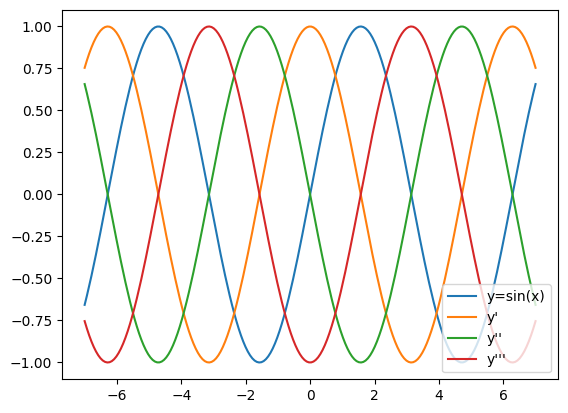

In [3]:
import matplotlib.pyplot as plt

x=Variable(np.linspace(-7,7,200))
y=F.sin(x)

y.backward(create_graph=True)

logs= [y.data]

for i in range(3):
    logs.append(x.grad.data)
    gx= x.grad
    x.cleargrad()
    gx.backward(create_graph=True)

labels=["y=sin(x)","y'","y''","y'''"]
for i,v in enumerate(logs):
    plt.plot(x.data,logs[i],label=labels[i])
plt.legend(loc='lower right')
plt.show()

    


In [14]:
print(logs[0].shape,
logs[1].shape,
logs[2].shape)

(200,) (200,) (200,)


tanh 함수 미분 및 계산 그래프 그리기

In [2]:
from dezero.utils import plot_dot_graph

x=Variable(np.array(1.))
y=F.tanh(x)
x.name='x'
y.name='y'

y.backward(create_graph=True)

iters=0

for i in range(iters):
    gx=x.grad
    x.cleargrad()
    gx.backward(create_graph=True)

gx=x.grad
gx.name='gx'+ str(iters+1)
plot_dot_graph(gx, verbose=False, to_file='tanh.png')

![nn](/home/myhwang/deep-learning-from-scratch-3/tanh.png)

double backprop의 활용법

- 같은 함수를 연속해서 미분하는 고차 미분 말고 미분된 식을 다른 함수 안에 넣을 수 있다.

In [4]:
#y=x^2
#z=(dy/dx)^3 + y 일때 dz/dx는?

x= Variable(np.array(2.))
y=x**2
y.backward(create_graph=True)
gx=x.grad
x.cleargrad()

z=gx**3 + y
z.backward()

print(x.grad)


variable(100.0)
